# image search 

### Functions
- dataset to vectorstor : (metadata -> vectors , image -> metadata) ---- save vectorstore
- search image to query: (image --VLM--> description -> cleaned_query)
- rag query to images : ( cleaned_query -> saved images / Image objects)
- load_vectorstore
- description to vector


### classes
- initialize VLM (imagea analyser)
- initialize embedding
- initialize vectorstore
- initialize image_dataset


### change to new dataset

In [25]:
!uv pip install torch transformers faiss-cpu

Using Python 3.12.3 environment at: /home/manodeep/projects/NN/.venv
Resolved 41 packages in 626ms                                        
Installed 1 package in 30ms                                 
 + faiss-cpu==1.11.0


In [4]:


import sys
print(sys.executable)



/home/manodeep/projects/NN/.venv/bin/python


Generating train split:   0%|          | 0/418 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ivanleomk/ecommerce-items",cache_dir = "data/wallmart_dataset")
def get_data(row):
    metadata = row
    metadata.pop('image')
    return metadata
data  = [get_data(dataset['train'][i]) for i in range(len(dataset['train']))]
metadata =[dataset['train'][i]["image"] for i in range(len(dataset['train']))] 

<class 'PIL.JpegImagePlugin.JpegImageFile'>


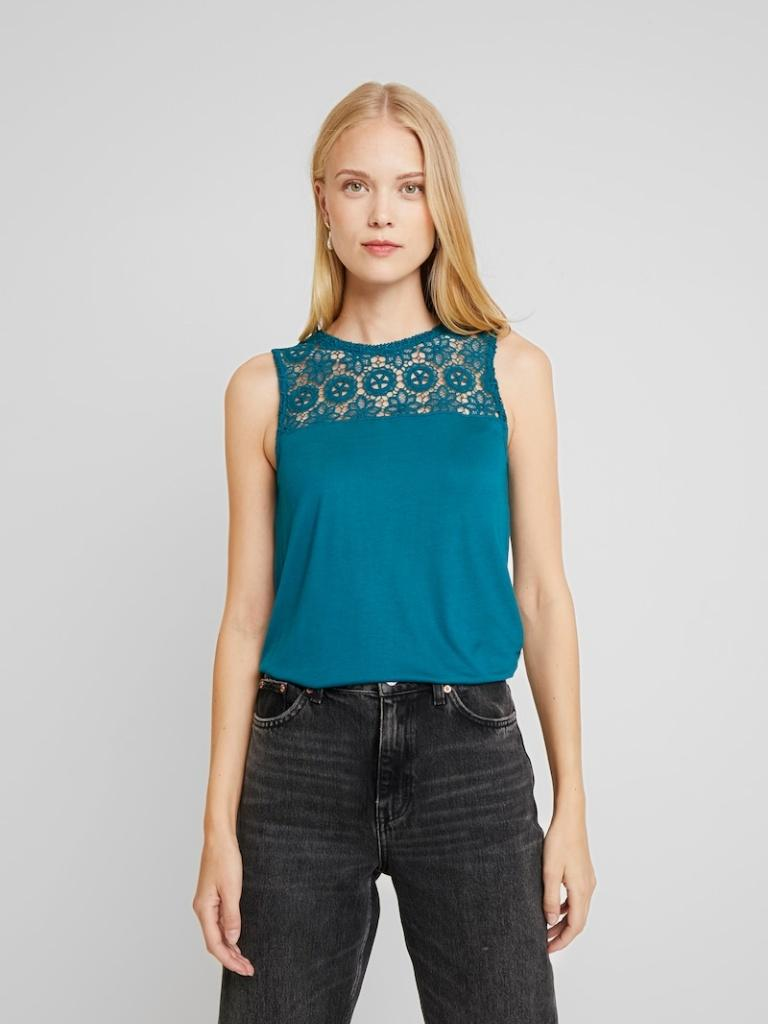

In [8]:
from PIL import Image
print(type(dataset["train"][0]["image"]))
dataset["train"][0]["image"]


In [8]:
len(dataset["train"])

418

In [15]:
metadata

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x10

In [42]:
from PIL import Image

test_image = Image.open(fp = "testImage.jpg")


In [ ]:
# k = 5

# index = faiss.read_index("./faiss_index/catalog.index")
# query_vector = encode_image(test_image)
# query_vector = np.array(query_vector).astype(np.float32).reshape(1, -1)

In [ ]:
# D , I = index.search(query_vector , k)

In [ ]:
# len(I[0])

5

In [ ]:
# for i in I[0]:
#     print(metadata_npy[i])
#     products['images'][i].show()

{'title': 'Black High-Waisted Jeans', 'category': 'Bottoms', 'subcategory': 'Jeans', 'brand': 'H&M', 'description': 'These timeless black high-waisted jeans offer a flattering fit with versatile styling options, making them a wardrobe essential. Pair them with a blouse or casual tee for a polished look.', 'id': 1}
{'title': 'Teal Lace Top', 'category': 'Tops', 'subcategory': 'Blouses', 'brand': 'H&M', 'description': 'This elegant teal blouse features a delicate lace design on the upper portion, offering a chic and stylish look for work or special events. Perfect for pairing with high-waisted jeans for a sophisticated ensemble.', 'id': 0}
{'title': 'Classic Denim Jeans', 'category': 'Bottoms', 'subcategory': 'Jeans', 'brand': 'Fictional Fashion Co.', 'description': 'Timeless denim jeans with a comfortable fit, ideal for everyday wear.', 'id': 142}
Opening in existing browser session.
{'title': 'Sleeveless Ruffled Blouse', 'category': 'Tops', 'subcategory': 'Blouses', 'brand': 'Fictional

[45271:45271:0100/000000.964377:ERROR:content/zygote/zygote_linux.cc:660] write: Broken pipe (32)


Opening in existing browser session.
Opening in existing browser session.


# using VLM

In [51]:
import requests
from PIL import Image

import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

model_id = "llava-hf/llava-onevision-qwen2-0.5b-ov-hf"
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
)

processor = AutoProcessor.from_pretrained(model_id)

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "give me the colour of the cloth( eg. red , gree , teal) , type of cloth (top  , bottom , pants , etc) ,design description(eg laced , short sleeved , etc) , some other feature  ?"},
          {"type": "image"},
        ],
    },
]


In [52]:
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

image_file = images[0]
# raw_image = Image.open(image_file)
inputs = processor(images=image_file, text=prompt, return_tensors='pt')#.to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


 
give me the colour of the cloth( eg. red , gree , teal) , type of cloth (top  , bottom , pants , etc) ,design description(eg laced , short sleeved , etc) , some other feature  ?assistant
The color of the cloth is teal, and it is a sleeveless top with a lace neckline. The design description is a sleeveless top with a lace neckline. The fabric appears to be a lightweight, stretchable material, suitable for casual wear.


In [53]:
query = processor.decode(output[0][2:], skip_special_tokens=True)


In [54]:
cleaned_query = query.split("assistant")[1].replace("\n" , "")
cleaned_query

'The color of the cloth is teal, and it is a sleeveless top with a lace neckline. The design description is a sleeveless top with a lace neckline. The fabric appears to be a lightweight, stretchable material, suitable for casual wear.'

In [ ]:
# RAG of metadata


from  langchain_core.documents import Document

import json


In [18]:

docs = []
for metadata_row , data_row in zip(metadata , data):
    
    
    metadata_row = {"image" : metadata_row}
    
    text = json.dumps(data_row)
    doc = Document(page_content=text , metadata = metadata_row)
    docs.append(doc)

In [35]:
!uv pip install sentence-transformers

Using Python 3.12.3 environment at: /home/manodeep/projects/NN/.venv
⠙ Resolving dependencies...                                                     

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 46 packages in 381ms                                        
Installed 1 package in 33mss==4.1.0                         
 + sentence-transformers==4.1.0


In [19]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore
# Initialize with an embedding model
from langchain_huggingface import HuggingFaceEmbeddings

from  langchain_core.documents import Document

import json

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)








docs = []
for metadata_row , data_row in zip(metadata , data):
    
    
    metadata_row = {"image" : metadata_row}
    
    text = json.dumps(data_row)
    doc = Document(page_content=text , metadata = metadata_row)
    docs.append(doc)
    
    
    

vector_store = InMemoryVectorStore(embedding=hf)
vector_store.add_documents(documents=docs, ids=[f"item_{i}" for i in range(len(data))])


['item_0',
 'item_1',
 'item_2',
 'item_3',
 'item_4',
 'item_5',
 'item_6',
 'item_7',
 'item_8',
 'item_9',
 'item_10',
 'item_11',
 'item_12',
 'item_13',
 'item_14',
 'item_15',
 'item_16',
 'item_17',
 'item_18',
 'item_19',
 'item_20',
 'item_21',
 'item_22',
 'item_23',
 'item_24',
 'item_25',
 'item_26',
 'item_27',
 'item_28',
 'item_29',
 'item_30',
 'item_31',
 'item_32',
 'item_33',
 'item_34',
 'item_35',
 'item_36',
 'item_37',
 'item_38',
 'item_39',
 'item_40',
 'item_41',
 'item_42',
 'item_43',
 'item_44',
 'item_45',
 'item_46',
 'item_47',
 'item_48',
 'item_49',
 'item_50',
 'item_51',
 'item_52',
 'item_53',
 'item_54',
 'item_55',
 'item_56',
 'item_57',
 'item_58',
 'item_59',
 'item_60',
 'item_61',
 'item_62',
 'item_63',
 'item_64',
 'item_65',
 'item_66',
 'item_67',
 'item_68',
 'item_69',
 'item_70',
 'item_71',
 'item_72',
 'item_73',
 'item_74',
 'item_75',
 'item_76',
 'item_77',
 'item_78',
 'item_79',
 'item_80',
 'item_81',
 'item_82',
 'item_83',
 '

In [22]:

vector_store.dump(path="data/walmart_dataset_index")

In [28]:
!uv pip install groq

Using Python 3.12.3 environment at: /home/manodeep/projects/NN/.venv
Audited 1 package in 3ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
cleaned_query = 'The dress in the image is a sleeveless, short-sleeved, tank-style top with a round neckline. It features a teal color with a lace overlay on the chest area, which adds a decorative and textured element to the garment. The fabric appears to be a lightweight, stretchable material, suitable for casual wear or light activities. The design is simple and modern, with clean lines and a minimalistic aesthetic. The quality of the dress seems to be good, with no visible signs of wear or damage.'


In [25]:
retrieved = vector_store.similarity_search(query=cleaned_query)
retrieved

[Document(id='item_398', metadata={'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024 at 0x70B0841B6DB0>}, page_content='{"title": "White Lace Trim Tank Top", "category": "Tops", "subcategory": "Tank Tops", "brand": "H&M", "description": "This elegant white tank top features delicate lace trimming along the neckline, providing a chic and feminine touch to any outfit. Perfect for layering or wearing alone on warm days, this piece is both versatile and stylish.", "id": 398}'),
 Document(id='item_138', metadata={'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024 at 0x70B084115610>}, page_content='{"title": "Red Lace Trim Tank Top", "category": "Tops", "subcategory": "Tank Tops", "brand": "Zara", "description": "This elegant red tank top features a delicate lace trim along the neckline, adding a touch of sophistication to a classic piece. Perfect for layering or wearing on its own, it\\u2019s ideal for both casual and semi-formal occasions.", "id

In [ ]:
from item_search_agent import imageSearch

searcher = imageSearch.imageSearcher()




# chat bot query

### Functions
- get response - groq 
- natural language query to database query
- get from database
- other tool calling 

# tavily web search AGENT

### function

- tool calling for searching basic internet

# virtual TryON

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/walmart-products.csv")

df.head()

,timestamp,url,final_price,sku,currency,gtin,specifications,image_urls,top_reviews,rating_stars,...,sizes,colors,seller,other_attributes,customer_reviews,ingredients,initial_price,discount,ingredients_full,categories
0,2024-08-24 00:00:00.000,https://www.walmart.com/ip/Laura-Mercier-Cavia...,22.90,173530386,USD,7.361501e+11,"[{""name"":""Brand"",""value"":""Laura Mercier""},{""na...","[""https://i5.walmartimages.com/seo/Laura-Merci...","{""negative"":{},""positive"":{}}","{""five_stars"":2,""four_stars"":3,""two_stars"":1}",...,[],"[""Sugar Frost"",""Tuxedo""]",Wal███t.c███,"[{""name"":""Instructions"",""value"":""Apply directl...","[{""name"":""Jac███"",""rating"":5,""review"":""My only...","Cyclopentasiloxane, trimethylsiloxysilicate, s...",NaN,NaN,"[{""type"":""Ingredients"",""values"":""Cyclopentasil...","[""Beauty"",""Makeup"",""Eye Makeup"",""Eye Shadow"",""..."
1,2024-08-24 00:00:00.000,https://www.walmart.com/ip/Exultantex-Grey-Bla...,47.88,430528189,USD,7.710779e+11,"[{""name"":""Brand"",""value"":""Exultantex""},{""name""...","[""https://i5.walmartimages.com/seo/Exultantex-...","{""negative"":{""rating"":1,""review"":""Color not ac...","{""five_stars"":47,""four_stars"":4,""one_star"":4,""...",...,"[""50\"" x 54\"""",""50\"" x 63\"""",""50\"" x 84\"""",""50...","[""Black"",""Blue"",""Green"",""Gray"",""Natural(Ivory)...",Exu███nte███ome███,"[{""name"":""Fabric Care Instructions"",""value"":""M...","[{""name"":""Dana"",""rating"":5,""review"":""I love th...",NaN,70.80,$22.92,NaN,"[""Home"",""Decor"",""Curtains & Window Treatments""..."
2,2024-08-24 00:00:00.000,https://www.walmart.com/ip/Jessica-London-Wome...,33.24,6013308220,USD,4.651920e+11,"[{""name"":""Features"",""value"":""Easy Care""},{""nam...","[""https://i5.walmartimages.com/seo/Jessica-Lon...","{""negative"":{},""positive"":{}}","{""five_stars"":2}",...,"[""S"",""M"",""L"",""1X"",""2X"",""3X""]","[""Aqua Sea"",""Dark Olive Green"",""Dark Sapphire""...",Ful███aut███ran███,"[{""name"":""Fabric Care Instructions"",""value"":""M...","[{""name"":""Bev███y F███"",""rating"":5,""review"":""V...",NaN,37.99,$4.75,NaN,"[""Clothing"",""Womens Plus"",""Plus Size Tops"",""Pl..."
3,2024-08-24 00:00:00.000,https://www.walmart.com/ip/100-Cotton-King-Per...,49.99,161657830,USD,8.407081e+11,"[{""name"":""Brand"",""value"":""Simply Put""},{""name""...","[""https://i5.walmartimages.com/asr/d88fe658-b9...","{""negative"":{""rating"":1,""review"":""[This review...","{""five_stars"":78,""four_stars"":17,""one_star"":2,...",...,"[""Queen"",""King""]","[""Beige"",""Blue"",""Gray"",""Spa Blue""]",IC ███bal███c,"[{""name"":""Fabric Care Instructions"",""value"":""M...","[{""name"":""Jes███oge███"",""rating"":5,""review"":""[...",NaN,71.99,$22.00,NaN,"[""Home"",""Bedding"",""Duvet Covers"",""King Duvet C..."
4,2024-08-25 00:00:00.000,https://www.walmart.com/ip/Disney-Boys-Graphic...,12.99,5397071399,USD,4.600086e+11,"[{""name"":""Country of Origin - Textiles"",""value...","[""https://i5.walmartimages.com/seo/Disney-Boys...","{""negative"":{""rating"":1,""review"":""This size sh...","{""five_stars"":12,""one_star"":1,""three_stars"":1,...",...,"[""2T"",""3T"",""3T-4T"",""3-4 Years"",""4-5 Years"",""4-...","[""1#Yellow Micky"",""2#Pink Minnie"",""3#Blue Dona...",Pat███,NaN,"[{""name"":""Mary"",""rating"":5,""review"":""Love thes...",NaN,29.00,$16.01,NaN,"[""Clothing"",""Kids Clothing"",""Boys Clothing"",""B..."


{'a': '1', 'b': '2'}